In [1]:
import autograd
import autograd.numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pickle
from matplotlib import colors, cm
from mpl_toolkits.mplot3d import axes3d, Axes3D
from pyDOE import lhs
from scipy.stats import multivariate_normal
from scipy.linalg import cholesky
from scipy.linalg import solve
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
from mintGP import mintGP
from scipy.optimize import minimize, basinhopping, differential_evolution, brute
from prosail_wrappers import prosail_2d, prosail_2d_transform, prosail_2d_L8
import scipy.io as sio
import copy
%matplotlib inline
#tfe.enable_eager_execution()

In [2]:
class AMOGAPE():
    
    def __init__(self, model, D, P, inputlimits, means, stdevs, startpoints = 50, startdata = None):
        """
        model (funcion) is an function taking N x D np.arrays and returning N x P np.arrays
        D (int) is the input dimension
        P (int) is the output dimension
        inputlimits (np.array) is a D x 2 array with the appropriate min and max in each column
        startpoints (int) is the number of LHC generated startpoints. Is ignored if startdata is provided
        startdata (dict) is a dictionary with keys:
            X (np.array) N x D
            Y (np.array) N x P
        """
        self.D = D
        self.P = P
        self.model = model
        self.inputlimits = inputlimits
        self.limdiffs = np.diff(self.inputlimits)
        self.data = {}
        self.tracker = {}
        
        self.means = means
        self.stdevs = stdevs
        self.GAUSSIAN = multivariate_normal(means, np.diag(np.square(stdevs)))
        self.covdet = np.linalg.det( np.diag(np.square(stdevs)) )
        self.covinv = np.linalg.inv( np.diag(np.square(stdevs)) )
        
        # Generate data
        if startdata == None:
            # Generate LHC startdata in intervals [0,1] and scale according to given limits
            self.data['X'] = np.zeros([startpoints, self.D])
            n = 0
            while startpoints > n:
                point = self.GAUSSIAN.rvs()
                if (lims[0,0] < point[0] < lims[0,1]) & (lims[1,0] < point[1] < lims[1,1]):
                    self.data['X'][n,:] = point
                    n += 1

            try:
                # Check if function accepts np.arrays 
                self.data['Y'] = self.model(self.data['X'])
            except ValueError:
                # Otherwise run loop
                print('Takes only one input at a time, running for starpoint for loop')
                Y = np.zeros([startpoints, P])
                for i in range(startpoints):
                    Y[i,:] = self.model(self.data['X'][i,:].reshape([1,D])).reshape([1,P])
                self.data['Y'] = Y
        else:
            self.data = copy.deepcopy(startdata)
         
        self.N = self.data['Y'].shape[0]

        # Train initial emulators
        self.train_emulators()
        
    
    def train_emulators(self):
        """ Trains an emulator for each output of the physical model
        """
        self.emudict = {'emu'+str(p) : mintGP() for p in range(self.P)}
        for p in range(self.P):
            y = self.data['Y'][:,p].reshape(self.N,1)
            self.emudict['emu'+str(p)].fit(self.data['X'], y)
        
        
    def force_likelihoodnoise(self, force_sigma):
        """ Forces to the likelihood variance to be a certain value for each emulator
        """
        for p in range(self.P):
            self.emudict['emu'+str(p)].likelihood_variance = force_sigma
            
    def force_jitter(self, force_jitter):
        """ Forces to the likelihood variance to be a certain value for each emulator
        """
        for p in range(self.P):
            self.emudict['emu'+str(p)].jitter = force_jitter
            
            
    def euclnorm(self,x):
        return(  np.sqrt( np.sum( np.square(x) ) )  )
    
    def normalpdf(self,x):
        diff = x.reshape(self.D,1) - self.means.reshape(self.D,1)
        return ( 1/np.sqrt(((2*np.pi)**self.D) * self.covdet) ) * np.exp(-0.5*np.dot(diff.T, np.dot(self.covinv, diff)))
    
    def A_add_D(self,x):
        x = x.reshape(1,self.D)
        self.DIVERSITY = 0.
        for p in range(self.P):
            emu_p = self.emudict['emu'+str(p)]
            self.DIVERSITY += emu_p.predvar(x) 
        self.GEOMETRY = np.nan
        return self.DIVERSITY * self.normalpdf(x)
    
    def A_prod_D(self,x):
        x = x.reshape(1,self.D)
        self.DIVERSITY = 1.
        for p in range(self.P):
            emu_p = self.emudict['emu'+str(p)]
            self.DIVERSITY *= emu_p.predvar(x) 
        self.GEOMETRY = np.nan
        return self.DIVERSITY * self.normalpdf(x)
    
    def A_add_G(self,x):
        x = x.reshape(1,self.D)
        self.DIVERSITY = 0.
        self.GEOMETRY = 0.
        for p in range(self.P):
            emu_p = self.emudict['emu'+str(p)]
            self.GEOMETRY += self.euclnorm( emu_p.geometric_info(x) ) 
        self.DIVERSITY = np.nan
        return self.GEOMETRY * self.normalpdf(x)
    
    def A_add_D_add_G(self,x):
        x = x.reshape(1,self.D)
        self.DIVERSITY = 0.#1.
        self.GEOMETRY = 0.#1.
        for p in range(self.P):
            emu_p = self.emudict['emu'+str(p)]
            self.DIVERSITY += emu_p.predvar(x) 
            self.GEOMETRY += self.euclnorm( emu_p.geometric_info(x) )  
        self.Aval = self.GEOMETRY*self.DIVERSITY
        return self.GEOMETRY * self.DIVERSITY * self.normalpdf(x)
    
    def A_prod_D_prod_G(self,x):
        x = x.reshape(1,self.D)
        self.DIVERSITY = 1.
        self.GEOMETRY = 1.
        for p in range(self.P):
            emu_p = self.emudict['emu'+str(p)]
            self.DIVERSITY *= emu_p.predvar(x) 
            self.GEOMETRY *= self.euclnorm( emu_p.geometric_info(x) )  
        self.Aval = self.GEOMETRY*self.DIVERSITY
        return self.GEOMETRY * self.DIVERSITY * self.normalpdf(x)
    
    def A_add_D_prod_G(self,x):
        x = x.reshape(1,self.D)
        self.DIVERSITY = 0.#1.
        self.GEOMETRY = 1.
        for p in range(self.P):
            emu_p = self.emudict['emu'+str(p)]
            self.DIVERSITY += emu_p.predvar(x) 
            self.GEOMETRY *= self.euclnorm( emu_p.geometric_info(x) )  
        self.Aval = self.GEOMETRY*self.DIVERSITY
        return self.GEOMETRY * self.DIVERSITY * self.normalpdf(x)
    
    def A_prod_D_add_G(self,x):
        x = x.reshape(1,self.D)
        self.DIVERSITY = 1.
        self.GEOMETRY = 0.#1.
        for p in range(self.P):
            emu_p = self.emudict['emu'+str(p)]
            self.DIVERSITY *= emu_p.predvar(x) 
            self.GEOMETRY += self.euclnorm( emu_p.geometric_info(x) )  
        self.Aval = self.GEOMETRY*self.DIVERSITY
        return self.GEOMETRY * self.DIVERSITY * self.normalpdf(x)
    
    
    def logA(self,x):
        x = x.reshape(1,self.D)
        self.DIVERSITY = 0.
        self.GEOMETRY = 0.
        for p in range(self.P):
            emu_p = self.emudict['emu'+str(p)]
            self.DIVERSITY += np.log( emu_p.predvar(x) )
            self.GEOMETRY += np.log( self.euclnorm( emu_p.geometric_info(x) )  )
        return np.min([0,self.GEOMETRY]) + self.DIVERSITY
    
    
    def update(self,limitscale,acq):
        """ AMOGAPE update step:
        Minimize acquisition function acq to find x*, compute corresponding model output f(x*),
        add data pair to database
        """
        # Define limits of update
        #limits = limitscale*self.inputlimits
        limits = self.inputlimits*limitscale + np.diff(self.inputlimits)*(1-limitscale)*0.7
        x0 = np.random.sample(self.D)*np.diff(limits).T + limits[:,0]
        bnds = tuple( ((minlim ,maxlim) for minlim, maxlim in limits) )
        
        # Define acquisition function
        negA = lambda x: - acq(x)
        negGradient = autograd.grad( lambda x: - acq(x) )
        
        self.d = np.random.uniform(low=0.05,high=0.15)
        brute_bnds = tuple( ((minlim + (maxlim-minlim)*self.d ,maxlim - (maxlim-minlim)*self.d) for minlim, maxlim in lims) ); self.brute_bnds = brute_bnds
        self.brutesol = brute( negA, ranges=brute_bnds, Ns=10, finish=False, full_output=True )
        
        x0 = self.brutesol[0]
        # Minimize acquisition function
        sol = minimize( negA, x0, args=(),
                        method='L-BFGS-B',
                        bounds=bnds, jac=negGradient)
        
        # Update database
        self.N += 1
        self.data['X'] = np.concatenate( [ self.data['X'], sol.x.reshape([1,self.D]) ], 0 )
        self.data['Y'] = np.concatenate( [ self.data['Y'], self.model(sol.x.reshape([1,self.D])).reshape([1,P]) ], 0 )
        
        # Train new emulators
        self.old_emudict = copy.deepcopy(self.emudict)
        try:
            self.train_emulators()
        except Exception as e:
            print('train_emulators error with A: ',str(acq),' deleting last update and run again')
            print(e)
            self.data['X'] = self.data['X'][0:-1,:]
            self.data['Y'] = self.data['Y'][0:-1,:]
            self.N -= 1
            self.emudict = self.old_emudict
            self.update(limitscale,acq)
                
        
        if type(self.DIVERSITY) is autograd.numpy.numpy_extra.ArrayNode:
            self.DIVERSITY = self.DIVERSITY.value[0,0]
        if type(self.GEOMETRY) is autograd.core.FloatNode:
            self.GEOMETRY = self.GEOMETRY.value
        self.tracker[self.N] = {'G': self.GEOMETRY, 'D': self.DIVERSITY,
                'lengthscale': [self.emudict['emu'+str(p)].lengthscale for p in range(self.P)] ,
                'likelihood_sigma': [self.emudict['emu'+str(p)].likelihood_variance for p in range(self.P)]}
        
        return sol.x
    
    def update_LHS(self):
        """ LHS update step:
        Refresh entire database generating N_t new datapoints
        """
        self.N += 1
        self.data['X'] = lhs(D, self.N)*self.limdiffs.T + self.inputlimits[:,0].T
        
        Y = np.zeros([self.N, P])
        for i in range(self.N):
            Y[i,:] = self.model(self.data['X'][i,:].reshape([1,D])).reshape([1,P])
        self.data['Y'] = Y
        # Retrain emulators
        self.train_emulators()
        self.tracker[self.N] = { 'lengthscale': [self.emudict['emu'+str(p)].lengthscale for p in range(self.P)] ,
                'likelihood_sigma': [self.emudict['emu'+str(p)].likelihood_variance for p in range(self.P)]}
        
        
    def update_gauss(self):
        """ LHS update step:
        Refresh entire database generating N_t new datapoints
        """
        self.N += 1
        Xnew = self.GAUSSIAN.rvs()
        lims = self.inputlimits
        while not (lims[0,0] < Xnew[0] < lims[0,1]) & (lims[1,0] < Xnew[1] < lims[1,1]):
            Xnew = self.GAUSSIAN.rvs()
        self.data['X'] = np.concatenate( [ self.data['X'], Xnew.reshape([1,self.D]) ], 0 )
        self.data['Y'] = np.concatenate( [ self.data['Y'], self.model(Xnew.reshape([1,self.D])).reshape([1,P]) ], 0 )
        # Retrain emulators
        self.train_emulators()
        self.tracker[self.N] = { 'lengthscale': [self.emudict['emu'+str(p)].lengthscale for p in range(self.P)] ,
                'likelihood_sigma': [self.emudict['emu'+str(p)].likelihood_variance for p in range(self.P)]}
    
    def test(self,Xt,Yt,pca=0):
        """ Compute RMSE of current emulator on input (Xt,Yt) input grid 
        """
        m = np.shape(Yt)[0]
        Yp = np.zeros((m, self.P))
        
        for p in range(self.P):
            emu_p = self.emudict['emu'+str(p)]
            Yp[:,p] = emu_p.predict(Xt).ravel()
            
        if pca:
                Yp = pca.inverse_transform( Yp )
                
        return np.sqrt( np.mean( np.square( Yp - Yt ) ) )
    
def trunc_gauss_sample(N,means,stdevs,lims):
    data = np.zeros([N,len(means)])
    n = 0
    nor2d = multivariate_normal(means, np.diag(np.square(stdevs)) )
    while N > n:
        point = nor2d.rvs()
        if (lims[0,0] < point[0] < lims[0,1]) & (lims[1,0] < point[1] < lims[1,1]):
            data[n,:] = point
            n += 1
    return(data)

In [3]:
def model(X):
    return np.reshape( ( 2*X[:,0]**2 + X[:,1]**2 )* np.sin(X[:,1]/3), (np.shape(X)[0], 1) )

D=2
P=1

emu = mintGP()
startpoints=10
startdata = {}
lims = np.array([[-12,12],[-12,12]]);
diffs = np.diff(lims)
startdata['X'] = lhs(D, startpoints)*diffs.T + lims[:,0].T 
startdata['Y'] = model(startdata['X'])

emu.fit(startdata['X'], startdata['Y'])

# Toy example (re-run cell to get idea of how amogape updates)

In [6]:
means=np.array([0,0]); stdevs=np.array([10,10])
amo = AMOGAPE(model, D=D, P=P, means=means, stdevs=stdevs ,inputlimits=lims, startpoints=30)
M = 100
Xt = trunc_gauss_sample(M,means,stdevs,lims); Yt = model(Xt)

0.000105050585067
('RMSE: ', 42.763921348058027)


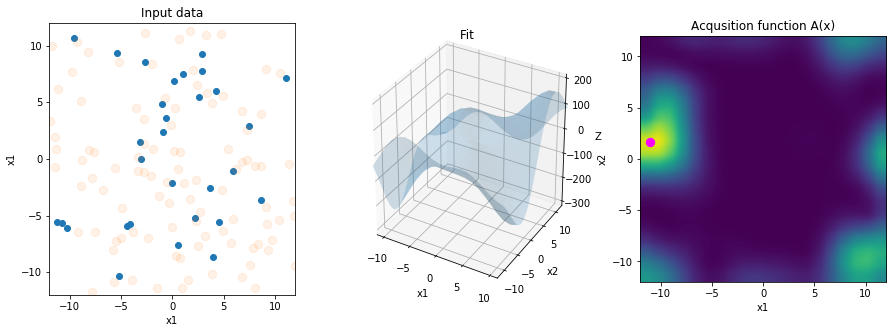

In [7]:
fig = plt.figure(figsize=[15,5])
acq = amo.A_prod_D_prod_G
#===============
# X data
#===============
ax = fig.add_subplot(1, 3, 1)
ax.scatter(amo.data['X'][:,0], amo.data['X'][:,1])
ax.scatter(Xt[:,0],Xt[:,1],alpha=0.1,s=70)
ax.set_xlabel('x1'), ax.set_ylabel('x1')
ax.set_xlim([-12,12]), ax.set_ylim([-12,12])
ax.set_title("Input data")
#===============
# Fit
#===============
ax = fig.add_subplot(1, 3, 2, projection='3d')

M = 20; grid = np.linspace(-12,12,M).reshape(M,1); XX1,XX2 = np.meshgrid(grid,grid)
Z = [[amo.emudict['emu0'].predict( np.array([XX1[i,j], XX2[i,j] ]).reshape(1,2) )[0,0] for i in range(M)] for j in range(M)]
Z = np.array(Z).T
ax.plot_surface(XX1, XX2, Z, rstride=1, cstride=1, alpha=0.2)
ax.set_xlabel('x1'), ax.set_ylabel('x2'), ax.set_zlabel('Z'), ax.axis('equal')
ax.set_xlim([-12,12]), ax.set_ylim([-12,12]); ax.set_title("Fit")


#===============
#  Acquisition function
#===============
ax = fig.add_subplot(1, 3, 3)

M = 20
lim0 = np.linspace(-12, 12,M)#np.linspace(-1, 1, M)
lim1 = np.linspace(-12, 12, M)#np.linspace(-2.5, 0, M)
x0, x1 = np.meshgrid(lim0, lim1)
ack = [[ np.float( acq(np.array([[ x0[i, j], x1[i, j] ]])) )
        for i in range(M)] for j in range(M)]
ack = np.array(ack).T
ax.imshow(ack, origin='lower',extent=[-12,12,-12,12], interpolation='gaussian')
ax.set_xlabel("x1"); ax.set_ylabel("x2"); ax.set_title("Acqusition function A(x)")

# Update
new = amo.update(1, acq)
#amo.force_likelihoodnoise( 1e-9 )
print( amo.emudict['emu0'].likelihood_variance )
ax.scatter(new[0],new[1],s=70,color='magenta',alpha=1)

print('RMSE: ',amo.test(Xt,Yt))
#print(amo.DIVERSITY.value[0,0], amo.GEOMETRY.value, amo.Aval.value[0,0])

#plt.savefig("figures/"+str(amo.N)+"rmse"+str(amo.test(Xt,Yt))+"A.png")#,format='pdf')

#### Plot RMSE on test set as function of added points:

0
10
20
30
40
50
60
70
80
90


Text(0,0.5,u'RMSE')

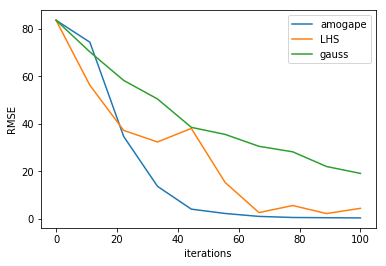

In [8]:
lims = np.array([[-12,12],[-12,12]]);
spoints = 50
amo_A = AMOGAPE(model, D=D, P=P, means=means, stdevs=stdevs, inputlimits=lims, startdata=startdata)
amo_LHS = AMOGAPE(model, D=D, P=P, means=means, stdevs=stdevs, inputlimits=lims, startdata=startdata)
amo_gauss = AMOGAPE(model, D=D, P=P, means=means, stdevs=stdevs, inputlimits=lims, startdata=startdata)
M = 500; Xt = trunc_gauss_sample(M,means,stdevs,lims); Yt = model(Xt)

amo_A_test=[]; amo_LHS_test=[]; amo_gauss_test=[]
acq = amo_A.A_prod_D_prod_G

for i in range(100):
    if not i%10:
        print(i)
        amo_A_test.append( amo_A.test(Xt,Yt) )
        amo_LHS_test.append( amo_LHS.test(Xt,Yt) )
        amo_gauss_test.append( amo_gauss.test(Xt,Yt) )
    amo_A.update(1, acq)
    amo_LHS.update_LHS()
    amo_gauss.update_gauss()
    
plt.plot(np.linspace(0,100,10), amo_A_test,label='amogape')
plt.plot(np.linspace(0,100,10), amo_LHS_test,label='LHS')
plt.plot(np.linspace(0,100,10), amo_gauss_test,label='gauss')
plt.legend(); plt.xlabel('iterations'); plt.ylabel('RMSE')

# Load prosail data generated from truncated gaussian

In [9]:
with open('prosail_L8_5000.pickle', 'rb') as handle:
    prosail = pickle.load(handle)
with open('L8response.pkl', 'rb') as handle:
    L8response = pickle.load(handle)

In [10]:
def trunc_gauss_sample(N,means,stdevs,lims):
    data = np.zeros([N,len(means)])
    n = 0
    nor2d = multivariate_normal(means, np.diag(np.square(stdevs)) )
    while N > n:
        point = nor2d.rvs()
        if (lims[0,0] < point[0] < lims[0,1]) & (lims[1,0] < point[1] < lims[1,1]):
            data[n,:] = point
            n += 1
    return(data)

### How well does a multioutput emulator with 30 startpoints do?

In [49]:
# Prosail init
plt.figure(figsize=(12,5))
lims = np.array([[20,90],[0,10]])
means=np.array([45,3.5]); stdevs=np.array([30,4.5])
spoints = 30
amo = AMOGAPE(prosail_2d_L8, D=2, P=9, means=means, stdevs=stdevs, inputlimits=lims, startpoints=spoints)

Takes only one input at a time, running for starpoint for loop


In [54]:
LAI = 4
chl = 10
L8spec_sim = []
for p in range(9):
    L8spec_sim.append( np.float( amo.emudict['emu'+str(p)].predict(np.array([[chl,LAI]])) ) )

In [55]:
L8spec = prosail_2d_L8(np.array([[chl,LAI]]))

In [56]:
np.arange(9)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

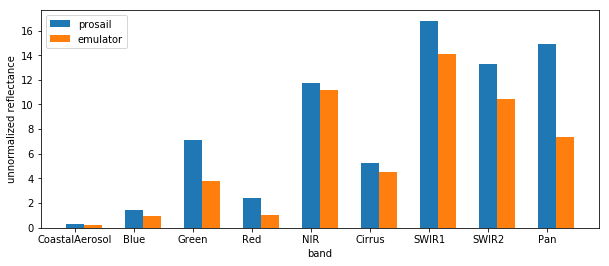

In [59]:
plt.figure(figsize=(10,4))
bands = L8response['bands']
plt.xlabel('band'); plt.ylabel('unnormalized reflectance'); #plt.savefig("sepctrumsave.pdf",format='pdf'); 

plt.bar(np.arange(len(bands)), L8spec.ravel(),  width=0.3, label='prosail' )
plt.bar(np.arange(0.3,len(bands)+0.3), L8spec_sim,  width=0.3, label='emulator')
tick = plt.xticks(range(len(bands)), bands) 
plt.legend()

In [36]:
# RMSE on testset
amo.test(prosail['X'],prosail['Y'])

4.9528155436374668

In [37]:
# RMSE on testset with 100 startpoints
amo = AMOGAPE(prosail_2d_L8, D=2, P=9, means=means, stdevs=stdevs, inputlimits=lims, startpoints=100)
amo.test(prosail['X'],prosail['Y'])

Takes only one input at a time, running for starpoint for loop


0.60489313340556616

# 2d PROSAIL experiments (takes ~1 day to run)


In [234]:
spoints = 30
D=2; P=9
lims = np.array([[20,90],[0,10]])
diffs = np.diff(lims)

R=15
resultsL8_freenoise_100 = {}
for run in range(R):
    sdata = {}
    
    sdata['X'] = trunc_gauss_sample(N=spoints,lims=lims,means=means,stdevs=stdevs)
    sdata['Y'] = np.zeros([spoints, P])
    for i in range(spoints):
        sdata['Y'][i,:] = prosail_2d_L8(sdata['X'][i,:].reshape([1,D])).reshape([1,P])
    
    amo_A_add_D = AMOGAPE(prosail_2d_L8, D=D, P=P, stdevs=stdevs, means=means, inputlimits=lims, startdata = sdata)
    amo_A_prod_D = AMOGAPE(prosail_2d_L8, D=D, P=P, stdevs=stdevs, means=means, inputlimits=lims, startdata = sdata)
    amo_A_add_D_add_G = AMOGAPE(prosail_2d_L8, D=D, P=P, stdevs=stdevs, means=means, inputlimits=lims, startdata = sdata)
    amo_A_add_D_prod_G = AMOGAPE(prosail_2d_L8, D=D, P=P, stdevs=stdevs, means=means, inputlimits=lims, startdata = sdata)
    amo_A_prod_D_prod_G = AMOGAPE(prosail_2d_L8, D=D, P=P, stdevs=stdevs, means=means, inputlimits=lims, startdata = sdata)
    amo_A_prod_D_add_G = AMOGAPE(prosail_2d_L8, D=D, P=P, stdevs=stdevs, means=means, inputlimits=lims, startdata = sdata)
    amo_LHS = AMOGAPE(prosail_2d_L8, D=D, P=P, stdevs=stdevs, means=means, inputlimits=lims, startdata = sdata)
    amo_gauss = AMOGAPE(prosail_2d_L8, D=D, P=P, stdevs=stdevs, means=means, inputlimits=lims, startdata = sdata)
    
    amo_A_add_D_test = []
    amo_A_prod_D_test = []
    amo_A_add_D_add_G_test = []
    amo_A_add_D_prod_G_test = []
    amo_A_prod_D_prod_G_test = []
    amo_A_prod_D_add_G_test = []
    amo_LHS_test = []
    amo_gauss_test = []

    # test
    for i in range(100+1):
        if not i%5:
            print(i)
            amo_A_add_D_test.append(amo_A_add_D.test( prosail['X'],prosail['Y'] ) )
            amo_A_prod_D_test.append(amo_A_prod_D.test( prosail['X'],prosail['Y'] ) )
            amo_A_add_D_add_G_test.append(amo_A_add_D_add_G.test( prosail['X'],prosail['Y'] ) )
            amo_A_add_D_prod_G_test.append(amo_A_add_D_prod_G.test( prosail['X'],prosail['Y'] ) )
            amo_A_prod_D_prod_G_test.append(amo_A_prod_D_prod_G.test( prosail['X'],prosail['Y'] ) )
            amo_A_prod_D_add_G_test.append(amo_A_prod_D_add_G.test( prosail['X'],prosail['Y'] ) )
            amo_LHS_test.append(amo_LHS.test( prosail['X'],prosail['Y'] ) )
            amo_gauss_test.append(amo_gauss.test(prosail['X'],prosail['Y']) )
            
        # update
        amo_A_add_D.update(1, amo_A_add_D.A_add_D)
        amo_A_prod_D.update(1, amo_A_prod_D.A_prod_D)
        amo_A_add_D_add_G.update(1, amo_A_add_D_add_G.A_add_D_add_G)
        amo_A_add_D_prod_G.update(1, amo_A_add_D_prod_G.A_add_D_prod_G)
        amo_A_prod_D_prod_G.update(1, amo_A_prod_D_prod_G.A_prod_D_prod_G)
        amo_A_prod_D_add_G.update(1, amo_A_prod_D_add_G.A_prod_D_add_G)
        amo_LHS.update_LHS()
        amo_gauss.update_gauss()
    
    
    resultsL8_freenoise_100[run] = {'add_D_test':amo_A_add_D_test, 'add_D_tracker': amo_A_add_D.tracker,
                                 'prod_D_test':amo_A_prod_D_test, 'prod_D_tracker': amo_A_prod_D.tracker,
                                 'add_D_add_G_test':amo_A_add_D_add_G_test, 'add_D_add_G_tracker': amo_A_add_D_add_G.tracker,
                                 'prod_D_prod_G_test':amo_A_prod_D_prod_G_test, 'prod_D_prod_G_tracker': amo_A_prod_D_prod_G.tracker,
                                 'add_D_prod_G_test':amo_A_add_D_prod_G_test, 'add_D_prod_G_tracker': amo_A_add_D_prod_G.tracker,
                                 'prod_D_add_G_test':amo_A_prod_D_add_G_test, 'prod_D_add_G_tracker': amo_A_prod_D_add_G.tracker,
                                 'lhs_test':amo_LHS_test, 'lhstracker': amo_LHS.tracker,
                                   'gauss_test':amo_gauss_test, 'gauss_tracker': amo_gauss.tracker}
    

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
